In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import xgboost
import lightgbm
import catboost
from catboost import CatBoostClassifier
from warnings import filterwarnings
import pickle
filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [3]:
df_train.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,B,Urban,7500,1


### Checking data quality

In [4]:
df_train.isnull().any()

perc_premium_paid_by_cash_credit    False
age_in_days                         False
Income                              False
Count_3.6_months_late                True
Count_6.12_months_late               True
Count_more_than_12_months_late       True
application_underwriting_score       True
no_of_premiums_paid                 False
sourcing_channel                    False
residence_area_type                 False
premium                             False
renewal                             False
dtype: bool

In [5]:
np.where(df_train.apply(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [6]:
df_train.isnull().sum()

perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3.6_months_late                 64
Count_6.12_months_late                64
Count_more_than_12_months_late        64
application_underwriting_score      1976
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
renewal                                0
dtype: int64

### Making train, test and validation sets

In [7]:
X = df_train.drop('renewal', axis = 1)
y = df_train['renewal']

In [8]:
random_state = 2021
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state )
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [9]:
cat_features = ['sourcing_channel', 'residence_area_type']
model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=5, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=100)
pred = model.predict(X_test)
f1_score(pred, y_test, pos_label=0)

0:	learn: 0.5648330	test: 0.5631307	best: 0.5631307 (0)	total: 132ms	remaining: 4m 23s
100:	learn: 0.1749035	test: 0.1692258	best: 0.1692252 (99)	total: 9.38s	remaining: 2m 56s
200:	learn: 0.1677609	test: 0.1691093	best: 0.1687799 (136)	total: 19.2s	remaining: 2m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1687798688
bestIteration = 136

Shrink model to first 137 iterations.


0.2570951585976628

### Applying cross-validation

In [10]:
cat_features = ['sourcing_channel', 'residence_area_type']

ff1=[]
num_splits = 5
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, cat_features=cat_features, 
                               use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)

    
    pred = model.predict(X_test)
    ff1.append(f1_score(y_test, pred, pos_label=0))
    

In [11]:
np.mean(ff1)

0.21087009142003915

In [12]:
model.best_iteration_

59

In [13]:
model.feature_importances_

array([22.62959856,  8.80481376,  5.83154523, 14.0766266 , 12.1729906 ,
        8.06408279,  9.53653114,  8.04974029,  4.17634859,  1.95510537,
        4.70261707])

In [14]:
  model.feature_names_

['perc_premium_paid_by_cash_credit',
 'age_in_days',
 'Income',
 'Count_3.6_months_late',
 'Count_6.12_months_late',
 'Count_more_than_12_months_late',
 'application_underwriting_score',
 'no_of_premiums_paid',
 'sourcing_channel',
 'residence_area_type',
 'premium']

In [15]:
X.columns

Index(['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',
       'Count_3.6_months_late', 'Count_6.12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score',
       'no_of_premiums_paid', 'sourcing_channel', 'residence_area_type',
       'premium'],
      dtype='object')

### Detemining important features

In [16]:
cat_features = ['sourcing_channel', 'residence_area_type']

ff1=[]
num_splits = 5
importance = []
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, cat_features=cat_features, 
                               use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)
    
    imp = pd.DataFrame({'Importance': model.feature_importances_, 'Features': X.columns })
    importance.append(imp)   
    

In [17]:
importance[0]

,Importance,Features
0,23.867953,perc_premium_paid_by_cash_credit
1,10.834821,age_in_days
2,6.657610,Income
3,12.172279,Count_3.6_months_late
4,10.068025,Count_6.12_months_late
5,7.449410,Count_more_than_12_months_late
6,8.985434,application_underwriting_score
7,8.322320,no_of_premiums_paid
8,4.779199,sourcing_channel
9,2.426751,residence_area_type


In [18]:
len(importance)

5

In [19]:
tmp_df = pd.merge(importance[0], importance[1], left_on='Features', 
                  right_on='Features')[['Features', 'Importance_x', 'Importance_y']]
for i in range(2, len(importance)):
    tmp_df = pd.merge(tmp_df, importance[i], left_on='Features', 
                      right_on='Features')

tmp_df['mean'] = tmp_df.mean(axis=1)

In [20]:
tmp_df

,Features,Importance_x,Importance_y,Importance_x,Importance_y,Importance,mean
0,perc_premium_paid_by_cash_credit,23.867953,28.312345,26.169438,21.540631,22.629599,24.503993
1,age_in_days,10.834821,9.631644,11.458399,11.745235,8.804814,10.494982
2,Income,6.657610,5.372031,5.982993,6.583343,5.831545,6.085505
3,Count_3.6_months_late,12.172279,13.037788,13.691818,11.955285,14.076627,12.986759
4,Count_6.12_months_late,10.068025,11.220722,10.725089,10.208145,12.172991,10.878995
5,Count_more_than_12_months_late,7.449410,7.489077,6.676538,6.729727,8.064083,7.281767
6,application_underwriting_score,8.985434,8.429154,7.415256,8.881417,9.536531,8.649559
7,no_of_premiums_paid,8.322320,7.293596,7.499554,9.054805,8.049740,8.044003
8,sourcing_channel,4.779199,4.476802,4.382495,5.729730,4.176349,4.708915
9,residence_area_type,2.426751,2.019419,2.062678,2.613618,1.955105,2.215514


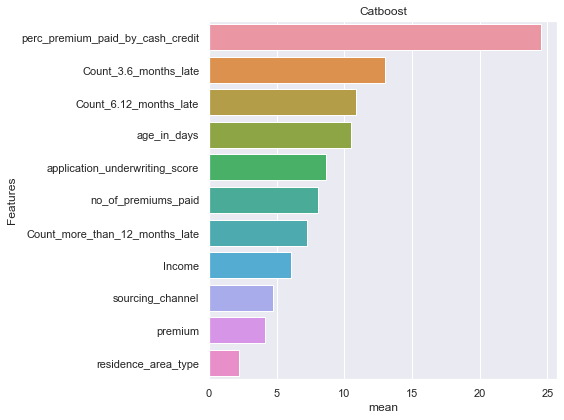

In [21]:
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="mean", y="Features", data=tmp_df.sort_values(by="mean", ascending=False))
plt.title('Catboost')
plt.tight_layout()
plt.show()

### Applying the model on test dataframe

In [22]:
result = model.predict(df_test)

In [23]:
result = pd.DataFrame(result)
result.head()

,0
0,1
1,1
2,1
3,1
4,1


In [24]:
result.to_csv('catboost_single_model.csv',  header=False, index=False)

## Training multiple models by cross-validation and save each model separately

The goal here is to save each model trained by one fold of cross-validation seperately on disk and use them as an emsemble to predict test data set.

In [25]:
cat_features = ['sourcing_channel', 'residence_area_type']

ff1=[]
num_splits = 5
i = 1
models = []
kfold = KFold(n_splits=num_splits)
for train_index, test_index in kfold.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, cat_features=cat_features, 
                               use_best_model=True)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False, use_best_model=True,
             early_stopping_rounds=100)
        
    models.append(model)
    # save the model to disk
    model_name = 'model_' + str(i) + '.sav'
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        print('Model {} saved as {}.'.format(i, model_name))
    i+=1
    
#     pickle.dump(model, model_name)
#     pickle.dump(model, open(model_name, 'wb'))

Model 1 saved as model_1.sav.
Model 2 saved as model_2.sav.
Model 3 saved as model_3.sav.
Model 4 saved as model_4.sav.
Model 5 saved as model_5.sav.


**Loading a sample model and check on test feature matrix**

In [26]:
# load the model from disk
filename = 'model_1.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9495632572555649


In [27]:
pred = loaded_model.predict(X_test)
print(f1_score(y_test, pred, pos_label=0))

0.3106546854942233


#### Loading each seperate model and use their average for prediction

Final prediction is the majority vote of all models

In [28]:
model_list = ['model_1.sav', 'model_2.sav', 'model_3.sav', 'model_4.sav', 'model_5.sav']
result_set = []
for model in model_list:
    loaded_model = pickle.load(open(model, 'rb'))
    res = loaded_model.predict(df_test)
    result_set.append(res)

In [29]:
len(result_set)

5

In [30]:
result_set[0]

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [31]:
result_df = pd.DataFrame(result_set)
result_df = result_df.T
result_df.head()

,0,1,2,3,4
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1


In [32]:
ensemble_res = result_df.mean(axis=1)
ensemble_res

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
26612    1.0
26613    0.0
26614    1.0
26615    1.0
26616    1.0
Length: 26617, dtype: float64

In [33]:
final_vote = ensemble_res.apply(lambda x: [0 if x<0.5 else 1])
final_vote
# df1['A'].apply(lambda x: [y if y <= 9 else 11 for y in x])

0        [1]
1        [1]
2        [1]
3        [1]
4        [1]
        ... 
26612    [1]
26613    [0]
26614    [1]
26615    [1]
26616    [1]
Length: 26617, dtype: object

In [34]:
final_vote_tmp = final_vote.values.tolist()
type(final_vote_tmp)

list

In [35]:
# final_vote_tmp

In [36]:
[list(x) for x in zip(*final_vote_tmp)][0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [37]:
len([list(x) for x in zip(*final_vote_tmp)][0])

26617

In [38]:
ensemble_vote = pd.DataFrame({'predicted_value': [list(x) for x in zip(*final_vote_tmp)][0]})
ensemble_vote.head()

,predicted_value
0,1
1,1
2,1
3,1
4,1


In [39]:
ensemble_vote.to_csv('ensemble_vote.csv', header=False, index=False)

### Labeling categorical parameters

+ Catboost can handle categorical data and therefore, does not require labeling. In this section we check if transforming categorical parameters to numerical values can have an impact on model accuracy. 
+ sourcing_channel and residence_area_type are categorical data types in this data set.

In [40]:
for col in df_train.columns:
    le = LabelEncoder()
    if df_train[col].dtype == 'object':
        df_train[col] = le.fit_transform(df_train[col]) 
        df_test[col] = le.transform(df_test[col])

df_train.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,2,1,3300,1
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,2,0,3300,0
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,0,1,9600,1
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,1,1,9600,1
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,1,1,7500,1


### Training a catboost model with whole train data

In [ ]:
model_le = CatBoostClassifier(iterations=2000, learning_rate=0.1, depth=8, thread_count=5, verbose=100 ,cat_features=cat_features)
model_le.fit(X, y, verbose=False, early_stopping_rounds=100) # use_best_model=True can only be used with nonempty eval_set.

In [ ]:
res_le = model_le.predict(df_test)
res_le